In [1]:
import os
%cd datasets
!bash get_datasets.sh
%cd ..

/Users/letunglam/Projects/deep-learning-training/minigrad/datasets
/Users/letunglam/Projects/deep-learning-training/minigrad


In [2]:
import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [3]:
cifar10_dir = 'datasets/cifar-10-batches-py'

try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape:', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape: (10000,)


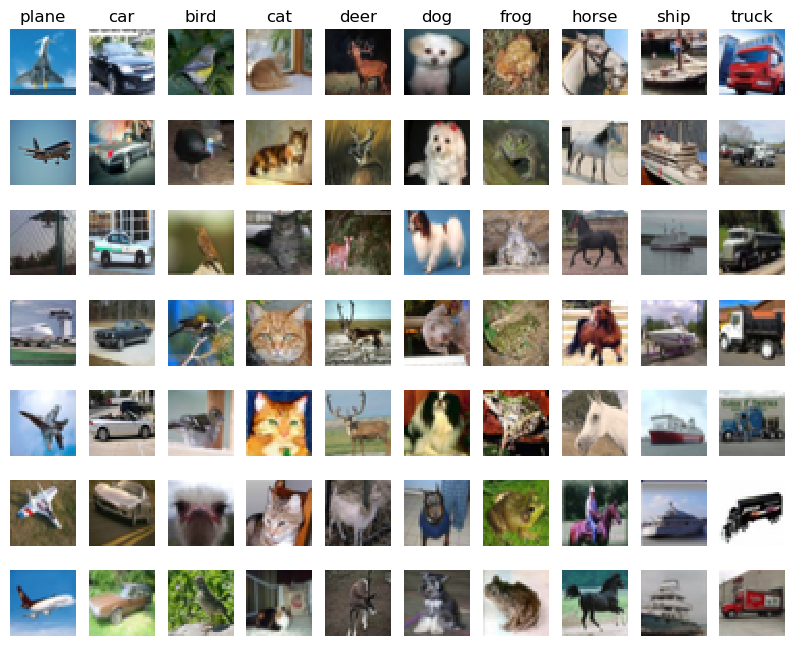

In [4]:
# Visualize some examples from the dataset.
# Show a few examples of trainign images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog','horse','ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will create a
# small development set as a subset of the training data; we can use this for
# development so out code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the orginal training set
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the orginal training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as out test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test data shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test data shape:  (1000,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# AS a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


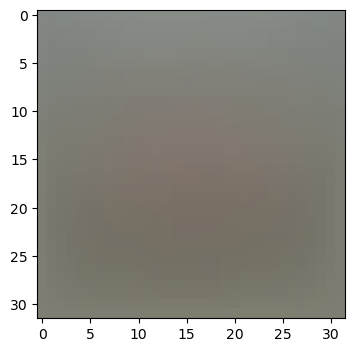

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# secound: subtract the mean image from the train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

#third: append the bias dimension of ones (i.e bias trick) so that our classifier
# only has to worry about optimizing a single weight matrx W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

In [8]:
# Evaluate the naive implementation of the loss
from classifiers.softmax import softmax_loss_naive
import time

# generate a random Softmax classifier weight matrix of small numbers
W = np.random.rand(3073, 10) * 0.0001

loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

# As a rough sanity check, out loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.285451
loss: 2.285451
sanity check: 2.302585


In [9]:
# Compute the loss and its gradient at W.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along serveral randomly chosen dimesions, and
# compute them with your analytically compted gradient. The numbers should math
# almost exactly along all dimesions.
from gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(W, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient chekc once again with regularization turned on
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 1.145685 analytic: 1.145685, relative error: 3.962821e-09
numerical: 0.134560 analytic: 0.134560, relative error: 1.554823e-07
numerical: -1.601905 analytic: -1.601905, relative error: 7.523432e-09
numerical: 2.074295 analytic: 2.074295, relative error: 8.138073e-09
numerical: 1.504657 analytic: 1.504657, relative error: 1.050408e-08
numerical: 1.797067 analytic: 1.797067, relative error: 9.264470e-09
numerical: -1.055062 analytic: -1.055063, relative error: 7.578462e-08
numerical: 0.005747 analytic: 0.005747, relative error: 3.371628e-06
numerical: -0.525594 analytic: -0.525594, relative error: 5.048903e-09
numerical: -2.953433 analytic: -2.953433, relative error: 3.738088e-09
numerical: -2.156237 analytic: -2.156237, relative error: 1.219947e-08
numerical: 2.392858 analytic: 2.392858, relative error: 2.646076e-10
numerical: 3.123146 analytic: 3.123146, relative error: 7.570707e-09
numerical: 0.135073 analytic: 0.135073, relative error: 1.766199e-07
numerical: 2.257819 anal

In [10]:
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, _ = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 2.285451e+00 computed in 0.024284s
Vectorized loss: 2.285451e+00 computed in 0.004923s
difference: 0.000000


In [11]:
tic = time.time()
_ , grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

from classifiers.softmax import softmax_loss_vectorized
tic = time.time()
_ , grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other is a matrix, so
# use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.037991s
Vectorized loss and gradient: computed in 0.003442s
difference: 0.000000


In [12]:
from classifiers.linear_classifier import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                          num_iters=1500, verbose=True)
toc = time.time()
print('That took %s' % (toc - tic))

iteration 0 / 1500: loss 770.570181
iteration 100 / 1500: loss 283.327029
iteration 200 / 1500: loss 104.824334
iteration 300 / 1500: loss 39.808599
iteration 400 / 1500: loss 15.873283
iteration 500 / 1500: loss 7.105419
iteration 600 / 1500: loss 3.881118
iteration 700 / 1500: loss 2.783700
iteration 800 / 1500: loss 2.302008
iteration 900 / 1500: loss 2.184274
iteration 1000 / 1500: loss 2.135353
iteration 1100 / 1500: loss 2.061858
iteration 1200 / 1500: loss 2.033558
iteration 1300 / 1500: loss 2.086971
iteration 1400 / 1500: loss 2.136064
That took 5.839261293411255


In [22]:
results = {}
best_val = -1
best_sofmax = None

num_folds = 5

for i in range(num_folds):
    lr = 10 ** np.random.uniform(-6.6, -6.4)
    reg = np.random.uniform(1e4, 2e4)
    softmax = Softmax()
    softmax.train(X_train, y_train, learning_rate=lr,reg=reg,
                  num_iters=1500, verbose=False)
    
    y_train_pred = softmax.predict(X_train)
    y_val_pred = softmax.predict(X_val)
    train_accuracy = np.mean(y_train == y_train_pred)
    val_accuracy = np.mean(y_val == y_val_pred)
    results[(lr, reg)] = (train_accuracy, val_accuracy)
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_sofmax = softmax
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train val_accuracy: %f val accuracy: %f' % (
          lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 2.545964e-07 reg 1.380490e+04 train val_accuracy: 0.344041 val accuracy: 0.361000
lr 2.844907e-07 reg 1.940654e+04 train val_accuracy: 0.335122 val accuracy: 0.350000
lr 3.194988e-07 reg 1.092694e+04 train val_accuracy: 0.353429 val accuracy: 0.360000
lr 3.380114e-07 reg 1.225990e+04 train val_accuracy: 0.350531 val accuracy: 0.369000
lr 3.559598e-07 reg 1.184674e+04 train val_accuracy: 0.349612 val accuracy: 0.354000
best validation accuracy achieved during cross-validation: 0.369000


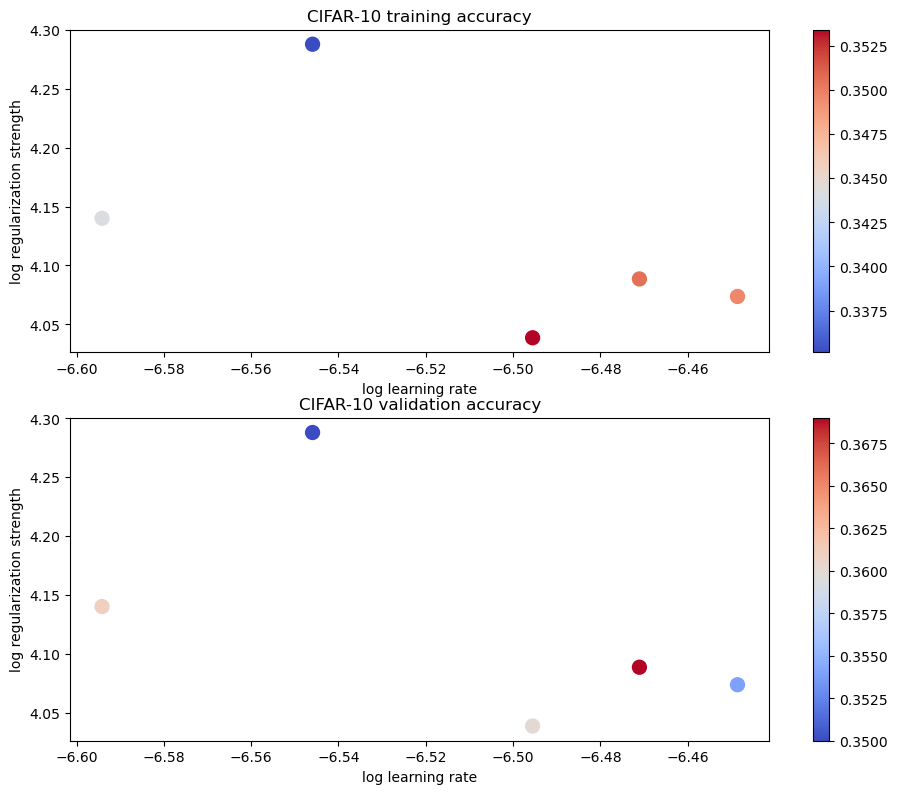

In [23]:
import math
import pdb

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

colors = [results[x][1] for x in results]
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [29]:
y_test_pred = best_sofmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Softmax classifier on raw pixels final test set accuracy: %f' % test_accuracy)

Softmax classifier on raw pixels final test set accuracy: 0.355000


In [30]:
best_sofmax.save("best_softmax.npy")

best_softmax.npy saved.


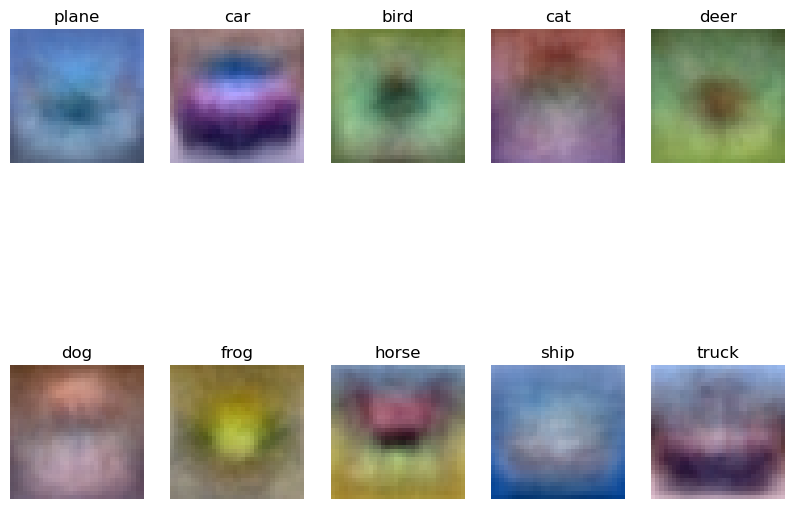

In [32]:
w = best_sofmax.W[:-1,:]
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])
plt.show()